# Experiment for downstream localization models at IAHS

In [109]:
# Dataset: MDCC Data Set 
# Candidates for downstream models:
# KNN, Random Forest (RF), Decision Tree (DT) and Gasussian Processes (GSs)

In [80]:
import numpy as np
import json
import math
import glob
import os
import google.protobuf
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
from pandas import DataFrame, concat
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import linalg as LA
import statistics
import matplotlib.pyplot as plt

In [81]:
buildingname =  'IAHS'
floorlevel = 2

In [82]:
import Data_pb2
from Utils import distance,offset_coord,gps_fromxy,gps2local,get_file_list,load_data_packs,location_interpolate
from Utils import parse_path_packages,parse_point_packages

#load building information
with open('building_dict.json') as fin:
    building_dict = json.load(fin)

#find a reference gps location for a local coordinate system
gpspo = np.array(building_dict[buildingname]['gpspo'])
gps_origin=tuple(np.min(gpspo,axis=0))

In [83]:
#Load the data packages
data_folder = os.path.join('FpData',buildingname,str(floorlevel))
print('The data folder is in:',data_folder)
#1. Load path-based data and verify the building and floor level
path_packages = []
path_data_files = get_file_list(data_folder, 1)
if len(path_data_files)>0:
    path_packages = load_data_packs(path_data_files)
    for i,path_package in enumerate(path_packages):
        assert path_package.buildingName==buildingname, "building mismatch, delete file and retry: "+path_data_files[i]
        assert int(path_package.floorLevel)==int(floorlevel), "floor mismatch, delete fine and retry:"+path_data_files[i]
print('The number of path-based collection',len(path_packages))
print(path_data_files)
#2. Load the point-based data and verify the building and floor level
point_packages = []
point_data_files = get_file_list(data_folder, 2)
if len(point_data_files)>0:
    point_packages = load_data_packs(point_data_files)
    for i,point_package in enumerate(point_packages):
        assert point_package.buildingName==buildingname, "building  mismatch,delete file and retry:"+point_data_files[i]
        assert int(point_package.floorLevel)==int(floorlevel), "floor  mismatch,delete file and retry:"+point_data_files[i]
print('The number of point-based collection',len(point_packages))

#3. Load the test data
test_packages = []
test_data_files = get_file_list(os.path.join('FpData',buildingname,str(floorlevel),'test'), 2)
if len(test_data_files)>0:
    test_packages = load_data_packs(test_data_files)
    for test_package in point_packages:
        assert test_package.buildingName==buildingname, "building name mismatch"
        assert test_package.floorLevel==floorlevel, "floor level mismatch"
print('The number of test points',len(test_packages))


The data folder is in: FpData/IAHS/2
The number of path-based collection 3
['/Users/lawrence/Downloads/IPS/FpData/IAHS/2/liu433_1_20190901131209.pbf', '/Users/lawrence/Downloads/IPS/FpData/IAHS/2/liu433_1_20190901130655.pbf', '/Users/lawrence/Downloads/IPS/FpData/IAHS/2/liu433_1_20190901130804.pbf']
The number of point-based collection 30
The number of test points 0


In [84]:
# APs seen by less than this value will be ignored.
Freq_threshold = 30

#Select the Effective Access Points since some Access Points may just temporary
AP_bssids = []
for pack in point_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
for pack in path_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
AP_bssids_count = dict(Counter(AP_bssids))
#remove APs only seen sporadically. 
AP_bssids_common = {k:v for k,v in AP_bssids_count.items() if v > Freq_threshold}
#create a dict for the AP_bssid index for convenience to organize the fingerprint vector
AP_bssids_index_dict = {k:v for k,v in zip(AP_bssids_common.keys(),range(len(AP_bssids_common)))}

if len(AP_bssids_index_dict)<3:
    print('Error, AP_bssids_index_dict is too small, please collect more data or set Freq_threshold to a smaller value')

In [85]:
path_FPs, path_labels = parse_path_packages(path_packages,AP_bssids_index_dict)
point_FPs, point_labels = parse_point_packages(point_packages,AP_bssids_index_dict)
test_FPs, test_labels = parse_point_packages(test_packages,AP_bssids_index_dict)
print (len(path_FPs[0]))
print (len(path_FPs))

path length is 57.241023 meter
path length is 56.485961 meter
path length is 56.913327 meter
10
27


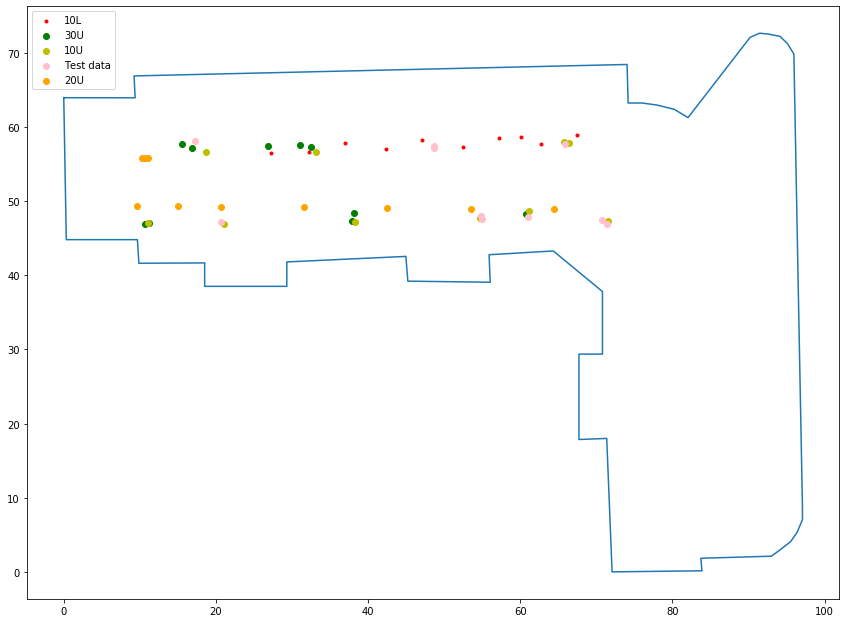

In [86]:
#plot your target building structure and the locations you collected data
local_poly = [offset_coord(gps_origin[1],gps_origin[0],lat,lon) for lon,lat in gpspo]
x_scale,y_scale=np.max(local_poly,axis=0) - np.min(local_poly,axis=0)
fig, ax = plt.subplots(1, 1, figsize=(x_scale*0.15,y_scale*0.15)) 
local_poly = np.array(local_poly)
ax.plot(*zip(*local_poly))

path_locs = gps2local(gps_origin,path_labels)
point_locs = gps2local(gps_origin,point_labels)
test_locs = gps2local(gps_origin,test_labels)

train_data = pd.DataFrame(np.append(np.array(path_FPs),np.array(point_FPs),axis=0),index=None, columns=None)
train_locs = pd.DataFrame(np.append(np.array(path_locs),np.array(point_locs),axis=0),index=None, columns=None)
# drop null
train_data.drop(train_locs[train_locs[0].isna()].index,inplace=True)
train_locs.dropna(inplace=True)
data_set = pd.concat([train_data,train_locs],axis=1)

# ax.scatter(np.array(data_set)[:,-2],np.array(data_set)[:,-1],c='black',marker='.',label="Test data")
ax.scatter(np.array(data_set)[15:25][:,-2],np.array(data_set)[15:25][:,-1],c='red',marker='.',label="10L")
ax.scatter(np.array(data_set)[25:35][:,-2],np.array(data_set)[25:35][:,-1],c='green',marker='o',label="30U")
ax.scatter(np.array(data_set)[35:45][:,-2],np.array(data_set)[35:45][:,-1],c='y',marker='o',label="10U")
ax.scatter(np.array(data_set)[45:55][:,-2],np.array(data_set)[45:55][:,-1],c='pink',marker='o',label="Test data")
ax.scatter(np.array(data_set)[:10][:,-2],np.array(data_set)[:10][:,-1],c='orange',marker='o',label="20U")


ax.legend()
plt.show()

# Downstream model performacne evaluation


In [87]:
training_data = pd.concat([data_set[15:25],data_set[35:45],
                           data_set[0:10],data_set[25:35]],axis=0).to_numpy()

In [88]:
test_data = np.array(data_set)[45:55]

In [89]:
training_data_10L =  training_data[:10]
training_data_10U =  training_data[10:20]
training_data_20L =  training_data[:20]
training_data_20U =  training_data[10:30]
training_data_30L =  training_data[:30]
training_data_30U =  training_data[10:40]
training_data_40L =  training_data[:40]

In [90]:
import downstream_models.localization_models as models
import importlib
importlib.reload(models)

<module 'downstream_models.localization_models' from '/Users/lawrence/Downloads/IPS/downstream_models/localization_models.py'>

# Label Propagation 

In [91]:
import DG_SSL.dg_ssl as dg_ssl
importlib.reload(dg_ssl)

<module 'DG_SSL.dg_ssl' from '/Users/lawrence/Downloads/IPS/DG_SSL/dg_ssl.py'>

In [92]:
propagation_results_10L_10U = dg_ssl.dg_ssl_init(training_data_10L,training_data_10U)[0]
print (dg_ssl.prop_error(propagation_results_10L_10U[10:,-2:],training_data_10U[:,-2:]))
print (dg_ssl.prop_error(propagation_results_10L_10U[:10,-2:],training_data_10L[:,-2:]))

12.991755350253742
0.9412372585944632


In [93]:
propagation_results_10L_20U = dg_ssl.dg_ssl_init(training_data_10L,training_data_20U)[0]
print (dg_ssl.prop_error(propagation_results_10L_20U[10:,-2:],training_data_20U[:,-2:]))
print (dg_ssl.prop_error(propagation_results_10L_20U[:10,-2:],training_data_10L[:,-2:]))

12.264507003264391
3.1819772993857693


In [94]:
propagation_results_10L_30U = dg_ssl.dg_ssl_init(training_data_10L,training_data_30U)[0]
print (dg_ssl.prop_error(propagation_results_10L_30U[10:,-2:],training_data_30U[:,-2:]))
print (dg_ssl.prop_error(propagation_results_10L_30U[:10,-2:],training_data_10L[:,-2:]))

12.21932116297959
4.5800501595667225


In [95]:
# model performance of KNN, DT and RF for different training data 

In [96]:
downstream_models_results_10L = models.evaluation_reg(training_data_10L,test_data,[10,0])
downstream_models_results_20L = models.evaluation_reg(training_data_20L,test_data,[20,0])
downstream_models_results_30L = models.evaluation_reg(training_data_30L,test_data,[30,0])
downstream_models_results_40L = models.evaluation_reg(training_data_40L,test_data,[40,0])
downstream_models_results_10L_10U = models.evaluation_reg(propagation_results_10L_10U,test_data,[10,10])
downstream_models_results_10L_20U = models.evaluation_reg(propagation_results_10L_20U,test_data,[10,20])
downstream_models_results_10L_30U = models.evaluation_reg(propagation_results_10L_30U,test_data,[10,30])

Knn error(m) - 13.116764317921756
Random Forest error(m)- 12.848530748209424
Decision Tree error(m)- 17.565213506404447
 
Knn error(m) - 10.755959155462296
Random Forest error(m)- 6.868005232159393
Decision Tree error(m)- 13.121205862412713
 
Knn error(m) - 10.755959155462296
Random Forest error(m)- 7.213091913466126
Decision Tree error(m)- 11.344902525539222
 
Knn error(m) - 9.96261928277966
Random Forest error(m)- 9.554349321121833
Decision Tree error(m)- 12.257504905441197
 
Knn error(m) - 11.241124844618858
Random Forest error(m)- 14.041579794385083
Decision Tree error(m)- 17.2030381171689
 
Knn error(m) - 10.959599747018112
Random Forest error(m)- 10.179016482651546
Decision Tree error(m)- 10.603108262230698
 
Knn error(m) - 11.543409125327694
Random Forest error(m)- 11.063952990291183
Decision Tree error(m)- 8.241795472573726
 


In [97]:
# Model performance of GPs for different training data 

In [107]:
import importlib
import gps_deployment.gps_starting as gps
import gps_deployment.main_controller as gps1
import gps_deployment.gaussian as gps2
importlib.reload(gps)
importlib.reload(gps1)
importlib.reload(gps2)

<module 'gps_deployment.gaussian' from '/Users/lawrence/Downloads/IPS/gps_deployment/gaussian.py'>

In [99]:
gps_results_10L = gps.gps_start(10,training_data_10L)
gps_results_20L = gps.gps_start(10,training_data_20L)
gps_results_30L = gps.gps_start(10,training_data_30L)
gps_results_40L = gps.gps_start(10,training_data_40L)

In [100]:
training_data_10L.shape

(10, 12)

In [106]:
rlt_10L = gps.gps_evaluation(gps_results_10L,10,test_data,[10,0])
rlt_20L = gps.gps_evaluation(gps_results_20L,10,test_data,[20,0])
rlt_30L = gps.gps_evaluation(gps_results_30L,10,test_data,[30,0])
rlt_40L = gps.gps_evaluation(gps_results_40L,10,test_data,[40,0])

GPs error: 17.65627649482782
GPs error: 26.998137929995757
GPs error: 31.989623541976854
GPs error: 37.388553291890574


In [102]:
gps_results_10L_10U = gps.gps_start(10,propagation_results_10L_10U)
gps_results_10L_20U = gps.gps_start(10,propagation_results_10L_20U)
gps_results_10L_30U = gps.gps_start(10,propagation_results_10L_30U)

In [108]:
rlt_10L_10U = gps.gps_evaluation(gps_results_10L_10U,10,test_data,[10,10])
rlt_10L_20U = gps.gps_evaluation(gps_results_10L_20U,10,test_data,[10,20])
rlt_10L_30U = gps.gps_evaluation(gps_results_10L_30U,10,test_data,[10,30])

GPs error: 15.656276494827821
GPs error: 15.656276494827821
GPs error: 14.990210735960204
